In [2]:
import cv2, os, glob
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, threshold_yen
from skimage.filters import threshold_otsu, threshold_yen, try_all_threshold, threshold_minimum
import skimage.measure as measure
from scipy.stats import linregress
from scipy.optimize import curve_fit

# Splitting videos into images

In [54]:
#Step 1: split into images

#find videos
print(f'Current directory: {os.getcwd()}') #troubleshooting, find current directory

path_to_videos = glob.glob(os.path.join('Videos','*.avi')) #issue may be encountered where the video type is .mp4 instead of .avi
print(path_to_videos, '-'*10, sep = '\n') #troubleshooting step, to ensure video paths are extracted correctly

#create required directories
def makefolders(path):
    folder = os.path.split(path) #create folders for extracting all images
    folder = os.path.splitext(folder[-1])
    folder_create = os.path.join('Videos',folder[0])
    if os.path.exists(folder_create) == False: #checking if the folder already exists, and if it does not, create a new folder with the video name as its name
        os.mkdir(folder_create)
    else:
        pass
    return folder_create

#navigate into folder for the image and save images
def saveimages(path, dir_name):
    cam = cv2.VideoCapture(path) #access the video. Idk how this actually works
    video_index = []
    count, success = 0, True
    while success:
        success, image = cam.read() #access next image of the video
        if not cam.isOpened():
            print(f"Error: Could not open video file {path}")
        os.chdir(dir_name) #change directory so that it saves into the directory that we want to save into
        if success:
            folder = os.path.split(dir_name)
            frame = f'{folder[-1]}_frame_{count:02}.jpg'
            video_index.append(frame)
            if os.path.exists(frame) == False:
                cv2.imwrite(frame, image)
                count+=1
            else:
                print(f'Image {folder[-1]}_frame_{count:02}.jpg already exists, skipping save')
                count+=1
        else:
            print('Image failed to save')
        os.chdir(os.path.join('..','..')) #exit directory for that particular video folder
    cam.release()
    print(f'Current directory: {os.getcwd()} \n Completed {path}\n--------------------')
    return video_index

Current directory: C:\Users\austi\Documents\learning-portfolio-2024-aug-immunoglobulinaustin\final_group_project
['Videos\\0.5ugDNA_drug10uM_5min45min_1.avi', 'Videos\\0.75ugDNA_drug10uM_5min45min_1.avi', 'Videos\\1ugDNA_drug10uM_5min45min_1.avi', 'Videos\\LipoKDEL1ug_biotin_drug25uM_live_5min1h.avi', 'Videos\\LipoKDEL1ug_biotin_no drug_live_5min1h.avi', 'Videos\\XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h.avi', 'Videos\\XtremeStr-li1.5ug_biotin_no drug_live_5min45min.avi']
----------


In [55]:
#this extracts images by calling the functions defined above
video_indexes, folder_indexes = [],[]
vf_dict = {}
for path in path_to_videos:
    dir_name = makefolders(path)
    folder_indexes.append(dir_name)
    img_names = saveimages(path, dir_name)
    video_indexes.append(img_names)
    vf_dict[os.path.split(dir_name)[-1]] = img_names #add new terms to dictionary

Image failed to save
Current directory: C:\Users\austi\Documents\learning-portfolio-2024-aug-immunoglobulinaustin\final_group_project 
 Completed Videos\0.5ugDNA_drug10uM_5min45min_1.avi
--------------------
Image failed to save
Current directory: C:\Users\austi\Documents\learning-portfolio-2024-aug-immunoglobulinaustin\final_group_project 
 Completed Videos\0.75ugDNA_drug10uM_5min45min_1.avi
--------------------
Image failed to save
Current directory: C:\Users\austi\Documents\learning-portfolio-2024-aug-immunoglobulinaustin\final_group_project 
 Completed Videos\1ugDNA_drug10uM_5min45min_1.avi
--------------------
Image failed to save
Current directory: C:\Users\austi\Documents\learning-portfolio-2024-aug-immunoglobulinaustin\final_group_project 
 Completed Videos\LipoKDEL1ug_biotin_drug25uM_live_5min1h.avi
--------------------
Image failed to save
Current directory: C:\Users\austi\Documents\learning-portfolio-2024-aug-immunoglobulinaustin\final_group_project 
 Completed Videos\LipoKD

# Old code

In [ ]:
cwd = os.getcwd() #getting current working directory

temp = glob.glob(os.path.join(cwd, 'Videos', '*')) #in my current working directory, access videos folder and list me all the files inside
video_folders = [file for file in temp if not file.endswith(".avi")] #using list comprehension. access the files inside temp, isolate the files with '.avi', and exclude it. store as video_folders

all_video_values = [] #empty list to add the arrays generated for all 7 videos into 1 list, for downstream works.

def extract_fluorescenceData(folder_path): #creating a function called extract_fluorescenceData, to loop through the 7 different folders.
    total_fluorescence = [] #empty list to add the max fluoresence later and plot
    subdir_path = os.path.join(cwd, 'Videos', folder_path) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, img)
            if img.lower().endswith(('.jpg')): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                total_fluorescence.append(img_gray.sum()) #sum up signal inside individual frames and append into total_fluorascence

    else:
        print(f'Subdirectory {video_folders} not found')
    return total_fluorescence #return here so can use in "histogrammer" function. this variable will be 'video1' in histogrammer function


def histogrammer(video1, i): #video1 is an array of the max fluorescence values, i simply stands for index
    video1_normalise = video1/max(video1) #normalising to highest sum fluorescent signal in the frames. 
    name = os.path.split(video_folders[i]) #split it by \\ into index, where [0] = your directory and [i] in this case is folder names
    x = range(1, len(video1)+1) #plotting frame 1 to n+1
    
    #plotting segment
    plt.figure(figsize = (13, 6)) #setting the figure size, has to be before plt.plot
    plt.plot(x, video1_normalise, linestyle = 'dashed', marker = 'o') #marker is the data point, marked as circle.
    
    #Labels & aesthetics
    plt.xticks(x) #this makes it show every tick in X axis
    plt.xlabel('Frame number', fontsize = 10)
    plt.ylabel('Total fluorescence signal', fontsize = 10)
    plt.grid(alpha = .25)
    plt.title(name[1], fontsize = 10) #name[1] as my first index will be my path, second index is filename
    plt.tight_layout()
    plt.savefig(f'Graph for {name[1]}.jpg', dpi = 300) #added saving of plots!
    plt.show() #visualisation purposes only, for the output
    

#calling of the functions to do all the dirty work
for i, folder in enumerate(video_folders): #for index inside folder, count the number of folders inside the path video_folders
    video1 = extract_fluorescenceData(folder) #isolate the single videos, split into frames, change to grayscale, give add sum(fluorescence) per frame and save as video1
    all_video_values.append(video1) #append numpy total_fluorescence of this video from each iteration into all_video_values. Placed here instead of extract_fluorescenceData function if not next time i call it, it will append junk
    histogrammer(video1, i) #store the list of fluorescence signals as video1 and plot histogram

# Crop and Plot

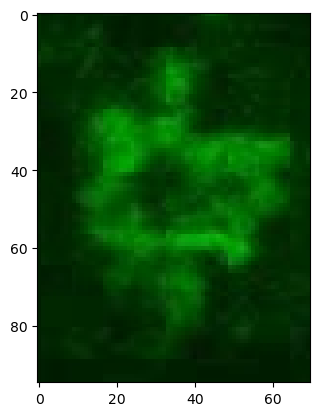

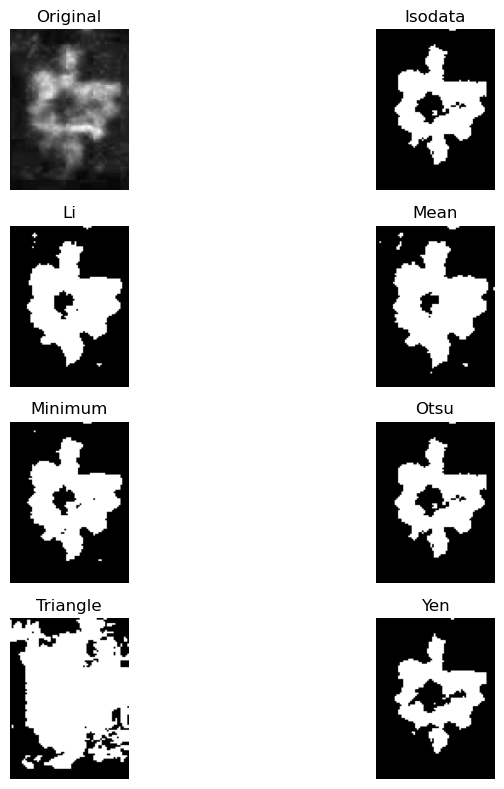

In [56]:
#here, testing on a single image for cropping
# video = {'1ugDNA_drug10uM_5min45min_1': (625,740, 600,720)}

img_path = '1ugDNA_drug10uM_5min45min_1_frame_01.jpg'
img = plt.imread(os.path.join('Videos',list(video.keys())[0], img_path))
img = img[695:790, 655:725]

plt.imshow(img)

img_grey = rgb2gray(img)
plt.show()

fig, ax = try_all_threshold(img_grey, figsize=(10, 8), verbose=False)
plt.show()

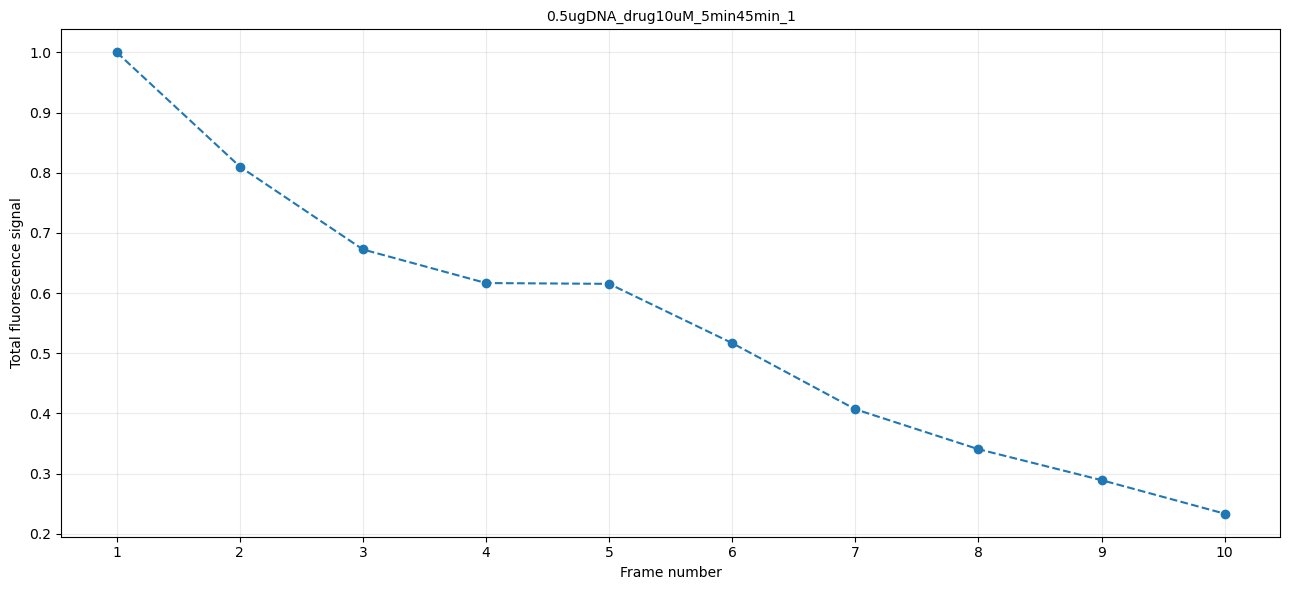

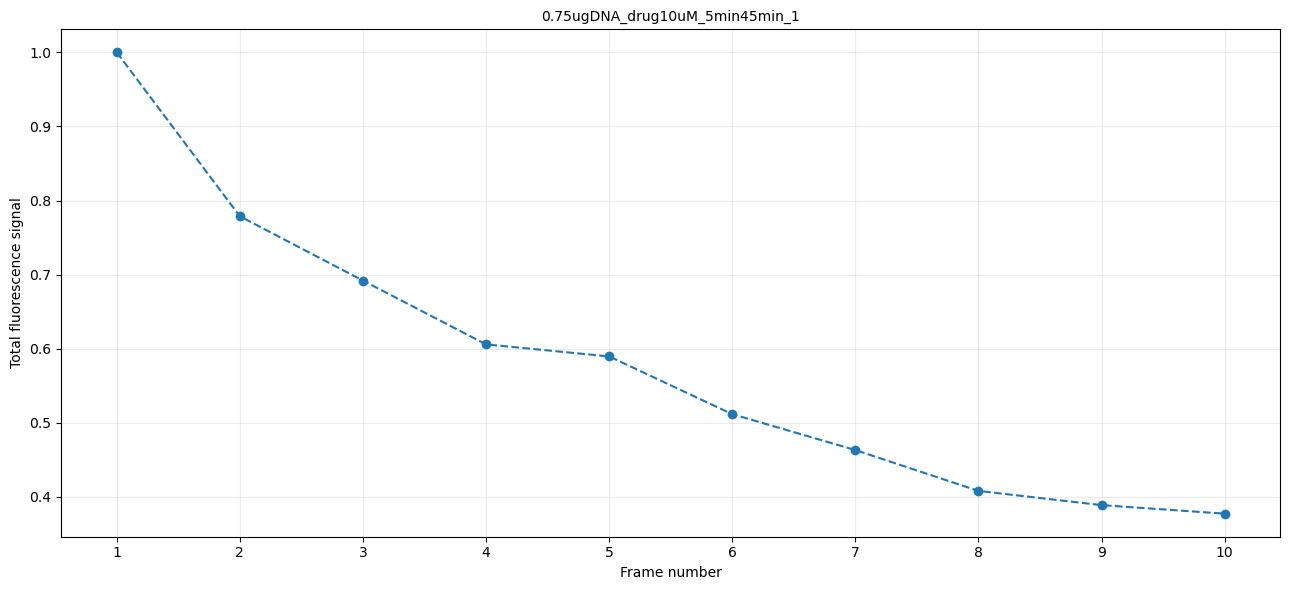

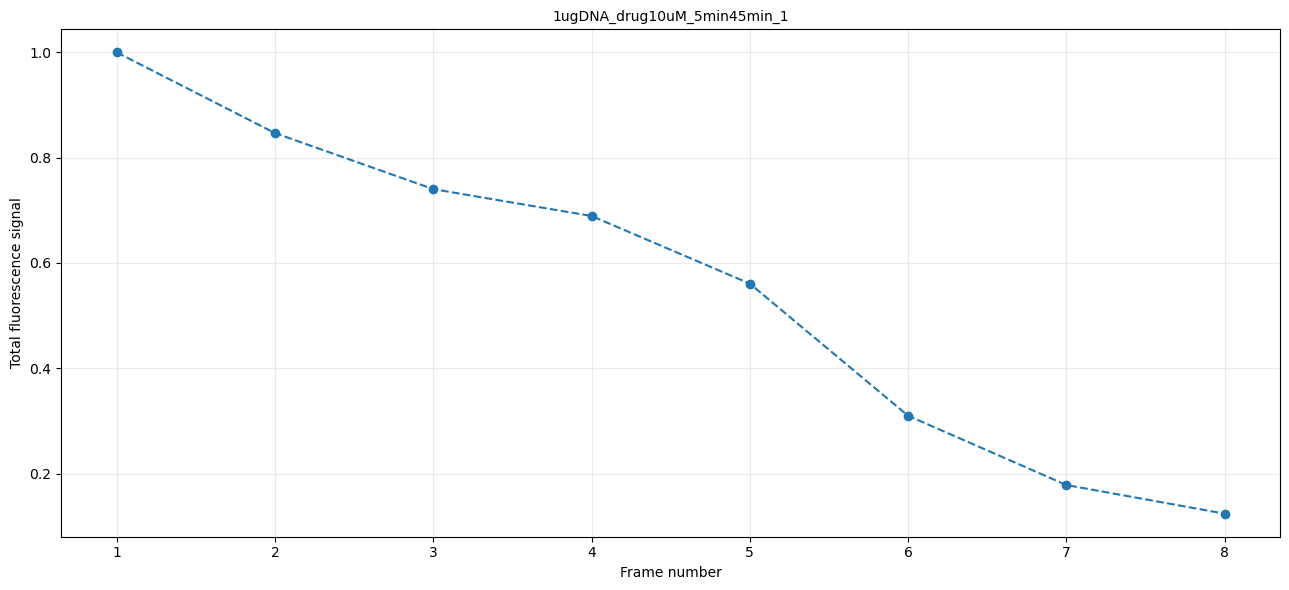

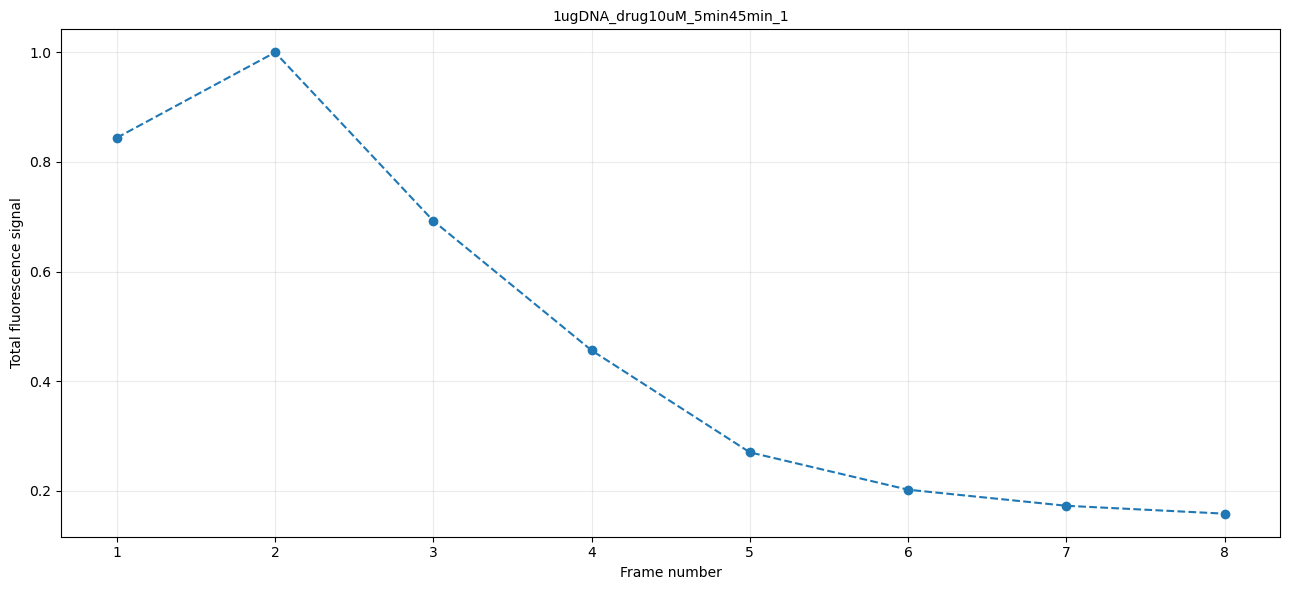

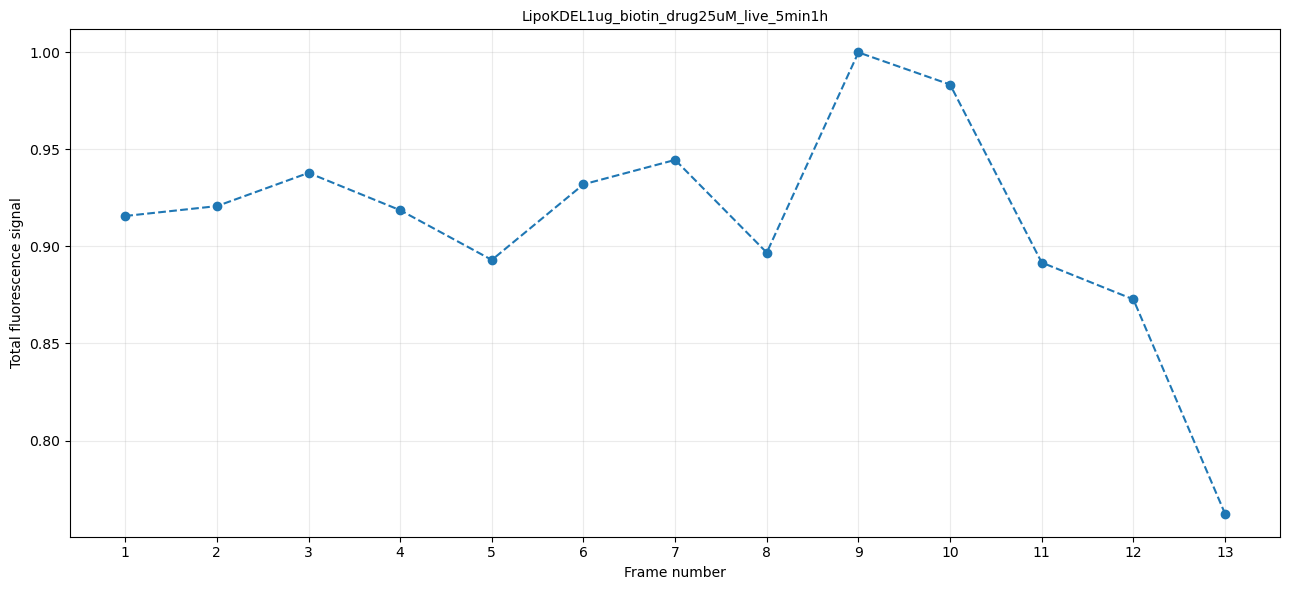

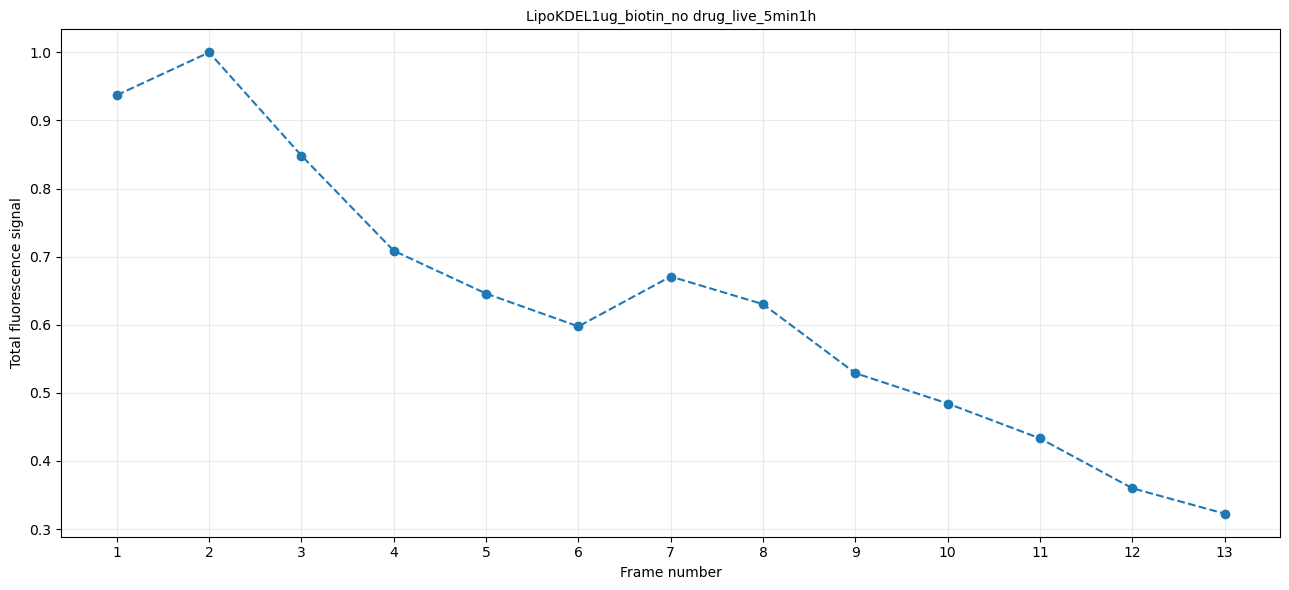

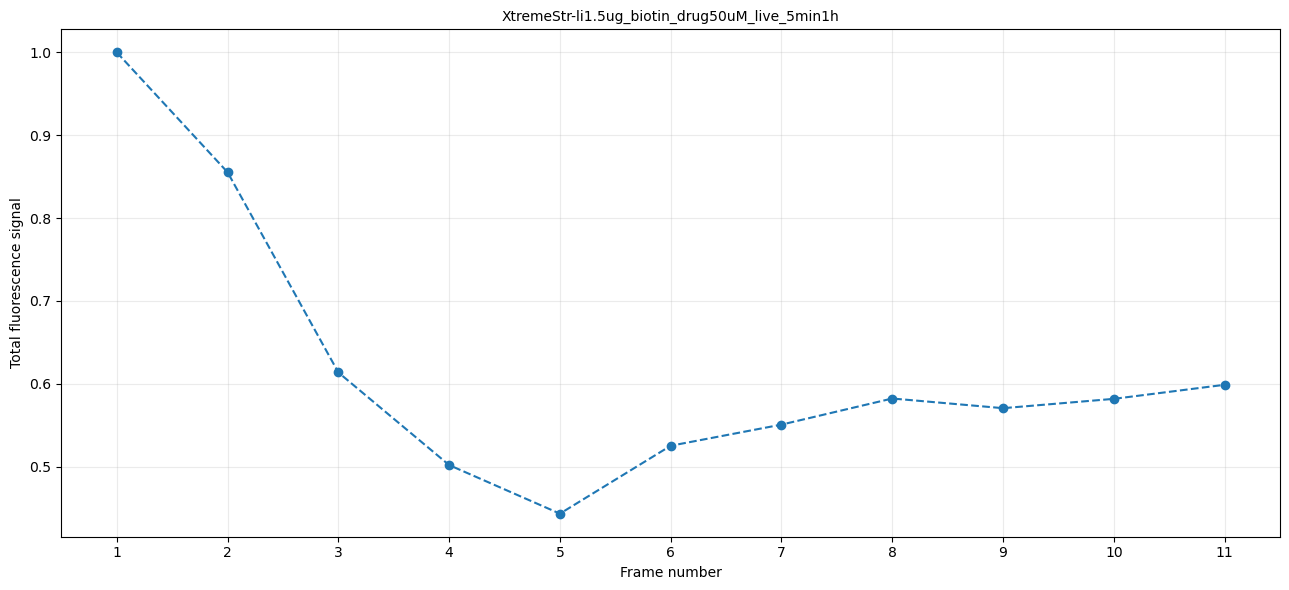

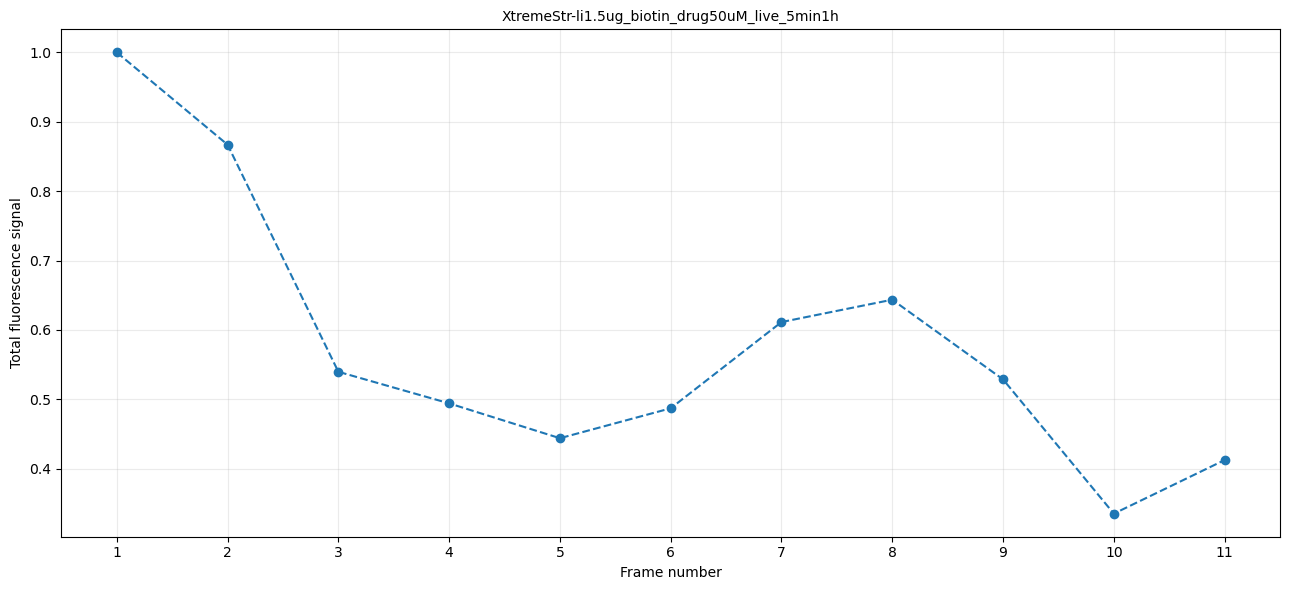

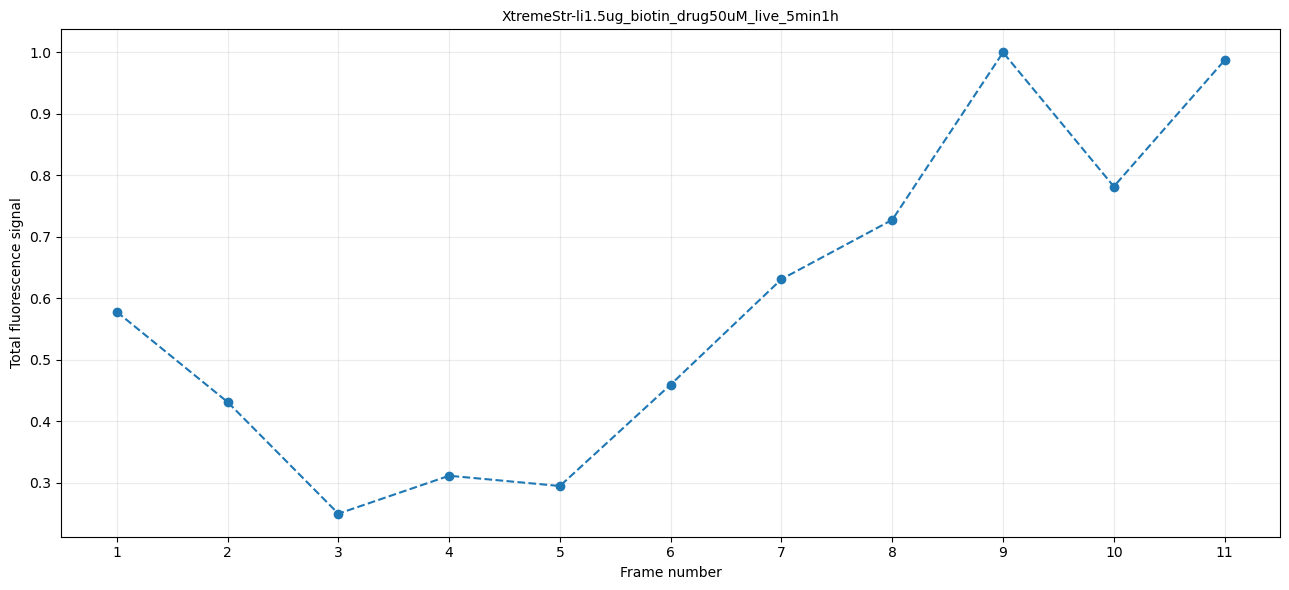

In [67]:
# This works, for our new approach.
cwd = os.getcwd() #getting current working directory

temp = glob.glob(os.path.join(cwd, 'Videos', '*')) #in my current working directory, access videos folder and list me all the files inside
video_folders = [file for file in temp if not file.endswith(".avi")] #using list comprehension. access the files inside temp, isolate the files with '.avi', and exclude it. store as video_folders

folders_to_process = ('LipoKDEL1ug_biotin_no drug_live_5min1h',  'LipoKDEL1ug_biotin_drug25uM_live_5min1h', 'XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h',
                       '0.5ugDNA_drug10uM_5min45min_1', '0.75ugDNA_drug10uM_5min45min_1', '1ugDNA_drug10uM_5min45min_1')

testing = {'Videos\\0.5ugDNA_drug10uM_5min45min_1': [(300,500, 400,600)],
           'Videos\\0.75ugDNA_drug10uM_5min45min_1': [(300,475, 375,550)],
           'Videos\\1ugDNA_drug10uM_5min45min_1': [(400,550, 180,300), (695,790, 655,725)],
           'Videos\\LipoKDEL1ug_biotin_drug25uM_live_5min1h': [(25,740, 600,720)],
           'Videos\\LipoKDEL1ug_biotin_no drug_live_5min1h': [(550,690, 450,600)],
           'Videos\\XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h': [(85,400, 70,150), (615,675, 650,715), (170,260, 970,1024)]
}
         #   'Videos\\XtremeStr-li1.5ug_biotin_no drug_live_5min45min': []
         # }

all_video_values = [] #empty list to add the arrays generated for all 7 videos into 1 list, for downstream works.

def extract_fluorescenceData(folder_path, resolutions): #creating a function called extract_fluorescenceData, to loop through the 7 different folders.
    total_fluorescence = [] #empty list to add the max fluoresence later and plot
    subdir_path = os.path.join(cwd, folder_path) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, img)
            if img.lower().endswith('.jpg'): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                y1, y2, x1, x2 = resolutions
                cropped_img = img_gray[y1:y2, x1:x2]
                total_fluorescence.append(cropped_img.sum()) #sum up signal inside individual frames and append into total_fluorascence

    else:
        print(f'Subdirectory {video_folders} not found')
    return total_fluorescence #return here so can use in "histogrammer" function. this variable will be 'video1' in histogrammer function


def histogrammer(video1, n): #video1 is an array of the max fluorescence values, i simply stands for index
    video1_normalise = video1/max(video1) #normalising to highest sum fluorescent signal in the frames.
    name = os.path.split(n) #split it by \\ into index, where [0] = your directory and [i] in this case is folder names
    x = range(1, len(video1)+1) #plotting frame 1 to n+1

    #plotting segment
    plt.figure(figsize = (13, 6)) #setting the figure size, has to be before plt.plot
    plt.plot(x, video1_normalise, linestyle = 'dashed', marker = 'o') #marker is the data point, marked as circle.

    #Labels & aesthetics
    plt.xticks(x) #this makes it show every tick in X axis
    plt.xlabel('Frame number', fontsize = 10)
    plt.ylabel('Total fluorescence signal', fontsize = 10)
    plt.grid(alpha = .25)
    plt.title(name[1], fontsize = 10) #name[1] as my first index will be my path, second index is filename
    plt.tight_layout()
    plt.savefig(f'Graph for {name[1]}.jpg', dpi = 300) #added saving of plots!
    plt.show() #visualisation purposes only, for the output

for key in testing.keys():
    for i in range(len(testing[key])):
        video1 = extract_fluorescenceData(key, testing[key][i])
        histogrammer(video1, key)

# Dr Chamika's playground

In [30]:
testing = {'Videos\\0.5ugDNA_drug10uM_5min45min_1': [(300,500, 400,600)], 
           'Videos\\0.75ugDNA_drug10uM_5min45min_1': [(300,475, 375,550)], 
           'Videos\\1ugDNA_drug10uM_5min45min_1': [(400,550, 180,300)], 
           'Videos\\LipoKDEL1ug_biotin_drug25uM_live_5min1h': [(25,740, 600,720)], 
           'Videos\\LipoKDEL1ug_biotin_no drug_live_5min1h': [(550,690, 450,600)], 
           'Videos\\XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h': [(85,400, 70,150)]}

def get_label(filepath):
    # x=list(testing.keys())[4]
    label=[fragments for fragments in filepath.split('_') if 'drug' in fragments]
    return label[0].upper()

for key in testing.keys():
    print(get_label(key))

DRUG10UM
DRUG10UM
DRUG10UM
DRUG25UM
NO DRUG
DRUG50UM


In [80]:
test = {}
for folder in folder_indexes:
  test[folder] = []
print(test)

{'Videos\\0.5ugDNA_drug10uM_5min45min_1': [], 'Videos\\0.75ugDNA_drug10uM_5min45min_1': [], 'Videos\\1ugDNA_drug10uM_5min45min_1': [], 'Videos\\LipoKDEL1ug_biotin_drug25uM_live_5min1h': [], 'Videos\\LipoKDEL1ug_biotin_no drug_live_5min1h': [], 'Videos\\XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h': [], 'Videos\\XtremeStr-li1.5ug_biotin_no drug_live_5min45min': []}


# For optimisation

#Definitely need to change this. Just used this to get over the initial hurdle
def extract_frames(video_path, frame_rate=13, output_dir="frames"):
  """Extracts frames from a video file and saves them with unique names.

  Args:
    video_path: The path to the video file.
    frame_rate: The desired frame rate for the extracted frames.
    output_dir: The directory to save the extracted frames.

  Returns:
    A list of extracted frames.
  """

  cap = cv2.VideoCapture(video_path)

  frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frame_interval = frame_count // frame_rate

  frames = []
  for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
      break
    if i % frame_interval == 0:
      frames.append(frame)

  #Create the output directory if it doesn't exist
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)

  #Save the extracted frames with unique names
  for i, frame in enumerate(frames, start = 1): #indicate starting no.
    filename = f"LipoKDEL1ug_biotin_no drug_live_5min1h_frame_{i:02d}.jpg"  #0 refers to adding leading zeros if needed, and 2 specifies the minimum character in the number which is 2. single digit no. will have leading zeros added to it.
    total_fluorescence.append(img.sum())
    output_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_path, frame)

  return frames

#Extract frames from the video file
current_directory = os.getcwd()
video_path = os.path.join(current_directory, "LipoKDEL1ug_biotin_drug25uM_live_5min1h.avi")
frames = extract_frames(video_path)

print(f"Extracted {len(frames)} frames.")

# Testing

In [ ]:
print(len(all_video_values))
print(all_video_values)
print(all_video_values[0][0], all_video_values[0][-1])
test = all_video_values[0][0] - all_video_values[0][-1]
print(test) #my shit works bro

In [ ]:
#mid testing. Want to create a function to loop through all the lists inside the list and minus last element with first in each list.
#shits broken af
compiled_rate_change = []

def rate_change(testing):
    rate_changes = []
    for i in range(1, len(all_video_values)):
        rate_change = all_video_values[i][0] - all_video_values[i][-1]/ len(all_video_values)
    rate_changes.append(rate_change)
    return(rate_changes)


test1 = rate_change(all_video_values)
compiled_rate_change.append(test1)
print(compiled_rate_change)

In [29]:
cwd = os.getcwd() #getting current working directory

temp = glob.glob(os.path.join(cwd, 'Videos', '*')) #in my current working directory, access videos folder and list me all the files inside
video_folders = [file for file in temp if not file.endswith(".avi")] #using list comprehension. access the files inside temp, isolate the files with '.avi', and exclude it. store as video_folders

all_video_values = [] #empty list to add the arrays generated for all 7 videos into 1 list, for downstream works.

def extract_fluorescenceData(folder_path): #creating a function called extract_fluorescenceData, to loop through the 7 different folders.
    total_fluorescence = [] #empty list to add the max fluoresence later and plot
    subdir_path = os.path.join(cwd, 'Videos', folder_path) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, img)
            if img.lower().endswith(('.jpg')): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                threshold_o = threshold_otsu(img_gray)
                threshold_y = threshold_yen(img_gray)
                img_gray_otsu = img_gray < threshold_o 
                img_gray_yen = img_gray < threshold_y
                
                # print(img_gray_otsu, img_gray_yen)

    else:
        print(f'Subdirectory {video_folders} not found')
    return total_fluorescence #return here so can use in "histogrammer" function. this variable will be 'video1' in histogrammer function
    return img_binarised

for i, folder in enumerate(video_folders): #for index inside folder, count the number of folders inside the path video_folders
    video1 = extract_fluorescenceData(folder) #isolate the single videos, split into frames, change to grayscale, give add sum(fluorescence) per frame and save as video1

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]] [[False  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [False  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]] [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  

Value of threshold_yen 0.080078125 and value of threshold_otsu 0.240234375
Value of threshold_yen 0.087890625 and value of threshold_otsu 0.310546875
Value of threshold_yen 0.083984375 and value of threshold_otsu 0.322265625
Value of threshold_yen 0.087890625 and value of threshold_otsu 0.322265625
Value of threshold_yen 0.099609375 and value of threshold_otsu 0.306640625
Value of threshold_yen 0.150390625 and value of threshold_otsu 0.275390625
Value of threshold_yen 0.240234375 and value of threshold_otsu 0.251953125
Value of threshold_yen 0.197265625 and value of threshold_otsu 0.259765625
Value of threshold_yen 0.208984375 and value of threshold_otsu 0.294921875
Value of threshold_yen 0.197265625 and value of threshold_otsu 0.318359375


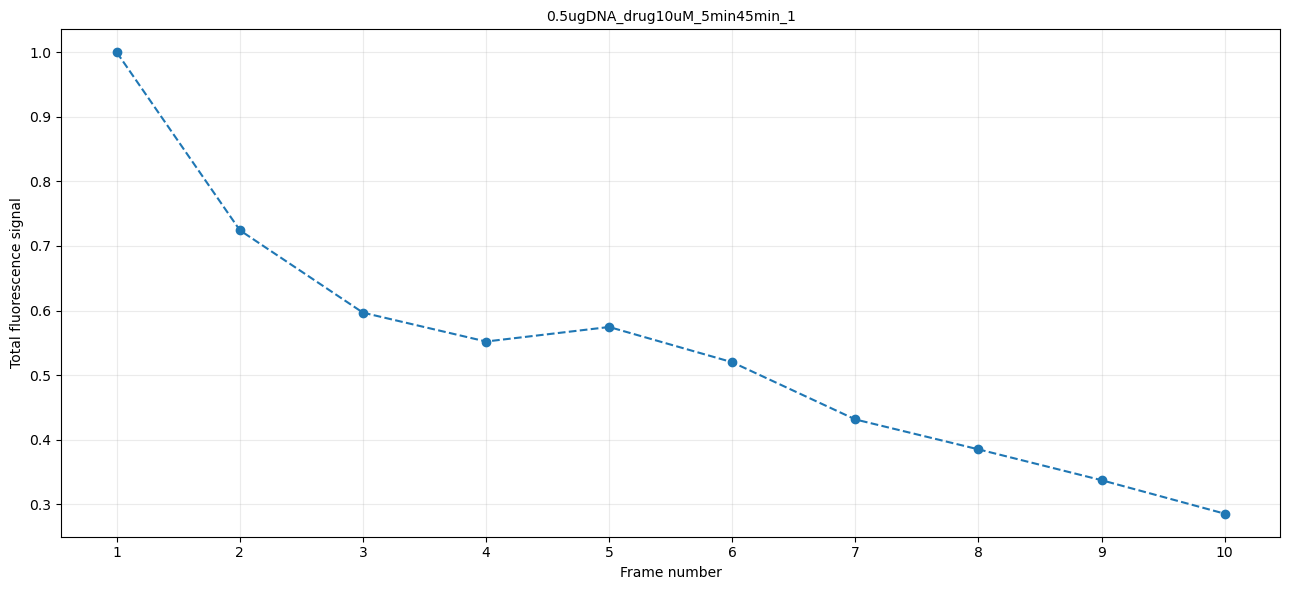

Value of threshold_yen 0.181640625 and value of threshold_otsu 0.275390625
Value of threshold_yen 0.111328125 and value of threshold_otsu 0.310546875
Value of threshold_yen 0.103515625 and value of threshold_otsu 0.302734375
Value of threshold_yen 0.177734375 and value of threshold_otsu 0.267578125
Value of threshold_yen 0.228515625 and value of threshold_otsu 0.220703125
Value of threshold_yen 0.310546875 and value of threshold_otsu 0.181640625
Value of threshold_yen 0.298828125 and value of threshold_otsu 0.162109375
Value of threshold_yen 0.306640625 and value of threshold_otsu 0.169921875
Value of threshold_yen 0.279296875 and value of threshold_otsu 0.181640625
Value of threshold_yen 0.279296875 and value of threshold_otsu 0.208984375


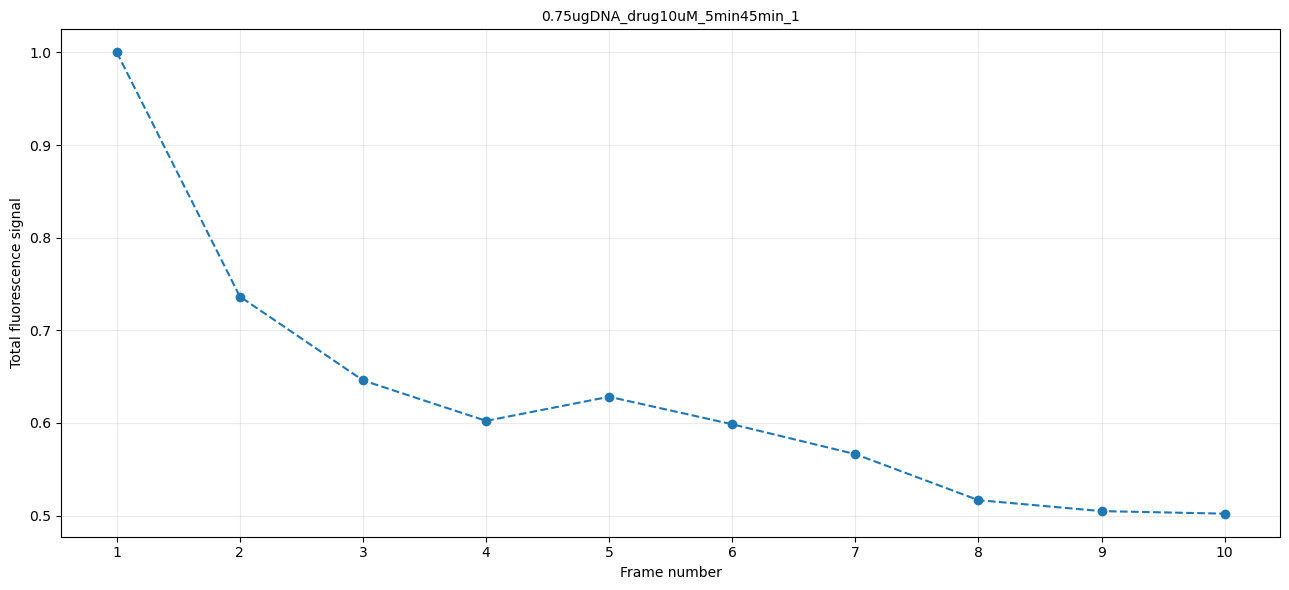

Value of threshold_yen 0.17201296032475488 and value of threshold_otsu 0.22647053691789215
Value of threshold_yen 0.18138654181985295 and value of threshold_otsu 0.2320967578125
Value of threshold_yen 0.16968418428308824 and value of threshold_otsu 0.2789061879595588
Value of threshold_yen 0.1540810409007353 and value of threshold_otsu 0.2750054021139706
Value of threshold_yen 0.1836824410232843 and value of threshold_otsu 0.2614789790134804
Value of threshold_yen 0.1836824410232843 and value of threshold_otsu 0.09421642233455882
Value of threshold_yen 0.15256382582720587 and value of threshold_otsu 0.090326595435049
Value of threshold_yen 0.15256382582720587 and value of threshold_otsu 0.4715296315870098
Value of threshold_yen 0.158203125 and value of threshold_otsu 0.232421875
Value of threshold_yen 0.15811366268382354 and value of threshold_otsu 0.23229044270833335


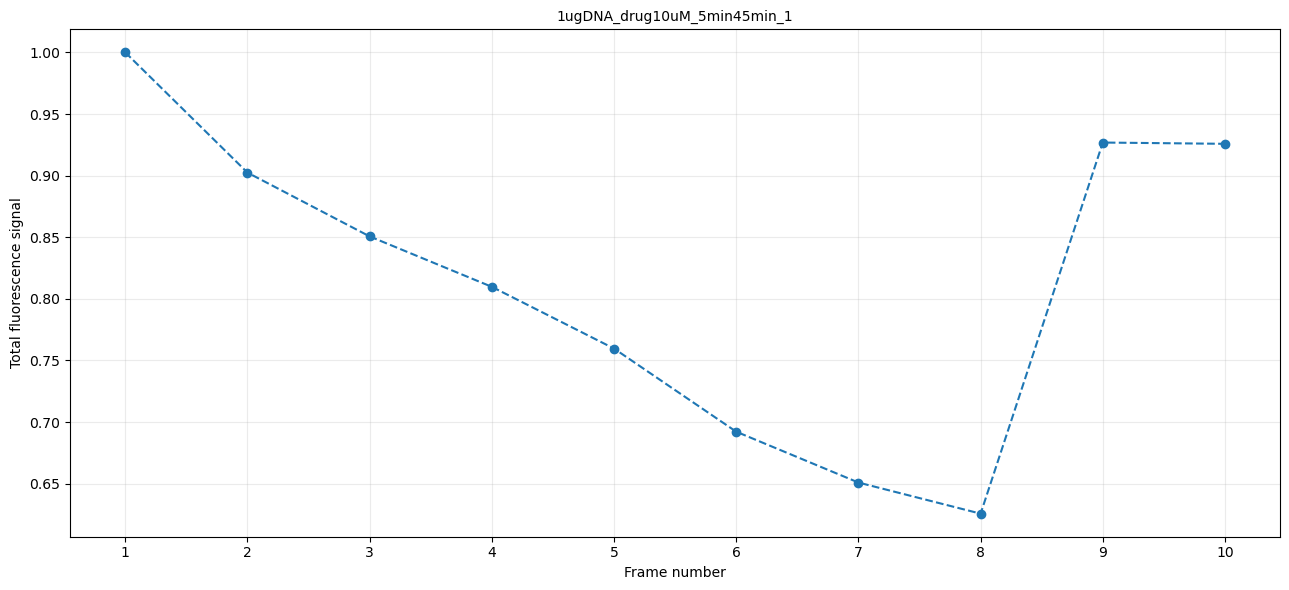

Value of threshold_yen 0.34430034237132356 and value of threshold_otsu 0.1488459995404412
Value of threshold_yen 0.26351579963235294 and value of threshold_otsu 0.1801435692401961
Value of threshold_yen 0.23827792356004904 and value of threshold_otsu 0.2322071484375
Value of threshold_yen 0.23361289751838235 and value of threshold_otsu 0.2365888579963235
Value of threshold_yen 0.23482046032475493 and value of threshold_otsu 0.21088971277573532
Value of threshold_yen 0.2034372242647059 and value of threshold_otsu 0.2426177267156863
Value of threshold_yen 0.20672129825367652 and value of threshold_otsu 0.23943977711397063
Value of threshold_yen 0.20276015625000002 and value of threshold_otsu 0.25382567708333337
Value of threshold_yen 0.21026657398897058 and value of threshold_otsu 0.2550041429227941
Value of threshold_yen 0.2185846346507353 and value of threshold_otsu 0.23081314568014707
Value of threshold_yen 0.2623435776654412 and value of threshold_otsu 0.20837575597426472
Value of th

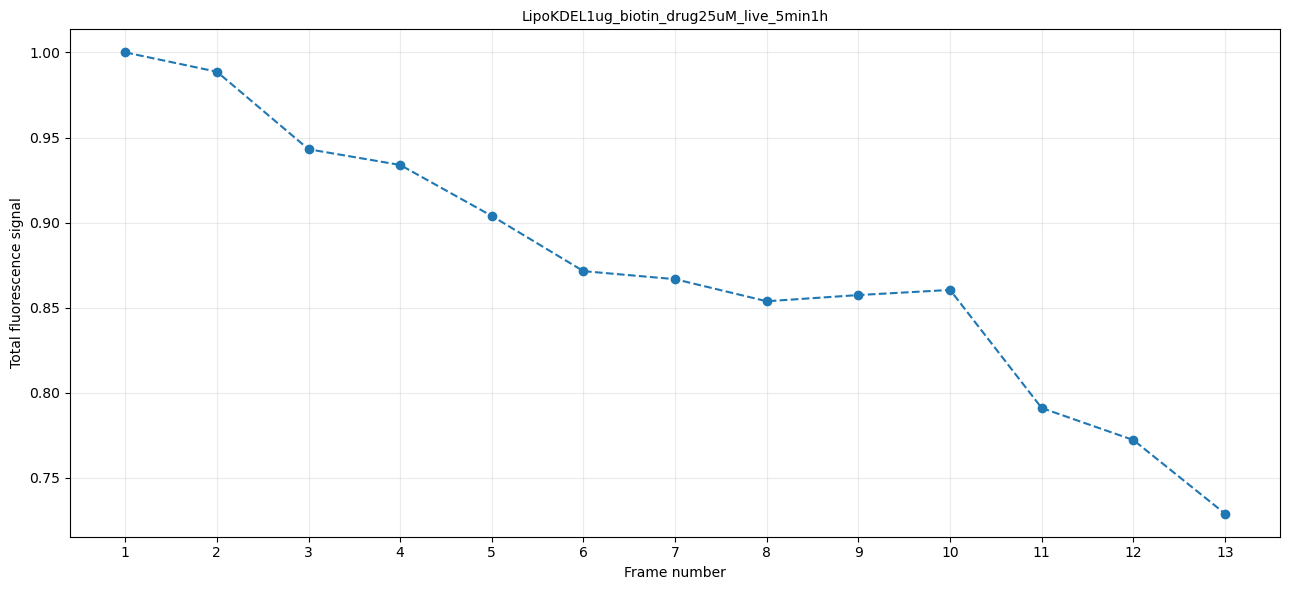

Value of threshold_yen 0.27698186197916663 and value of threshold_otsu 0.19403542202818627
Value of threshold_yen 0.27977411458333334 and value of threshold_otsu 0.15410018075980392
Value of threshold_yen 0.22505488281250002 and value of threshold_otsu 0.23995917968750002
Value of threshold_yen 0.15983715073529411 and value of threshold_otsu 0.2614159007352941
Value of threshold_yen 0.15283777037377452 and value of threshold_otsu 0.26179142846200987
Value of threshold_yen 0.13499741268382354 and value of threshold_otsu 0.28037924172794115
Value of threshold_yen 0.11773607919730393 and value of threshold_otsu 0.2816723920036765
Value of threshold_yen 0.15760205652573528 and value of threshold_otsu 0.2596681502757353
Value of threshold_yen 0.18408614813112745 and value of threshold_otsu 0.24004833716299018
Value of threshold_yen 0.2049824142156863 and value of threshold_otsu 0.2049824142156863
Value of threshold_yen 0.2716073307291667 and value of threshold_otsu 0.16703124617034315
Value

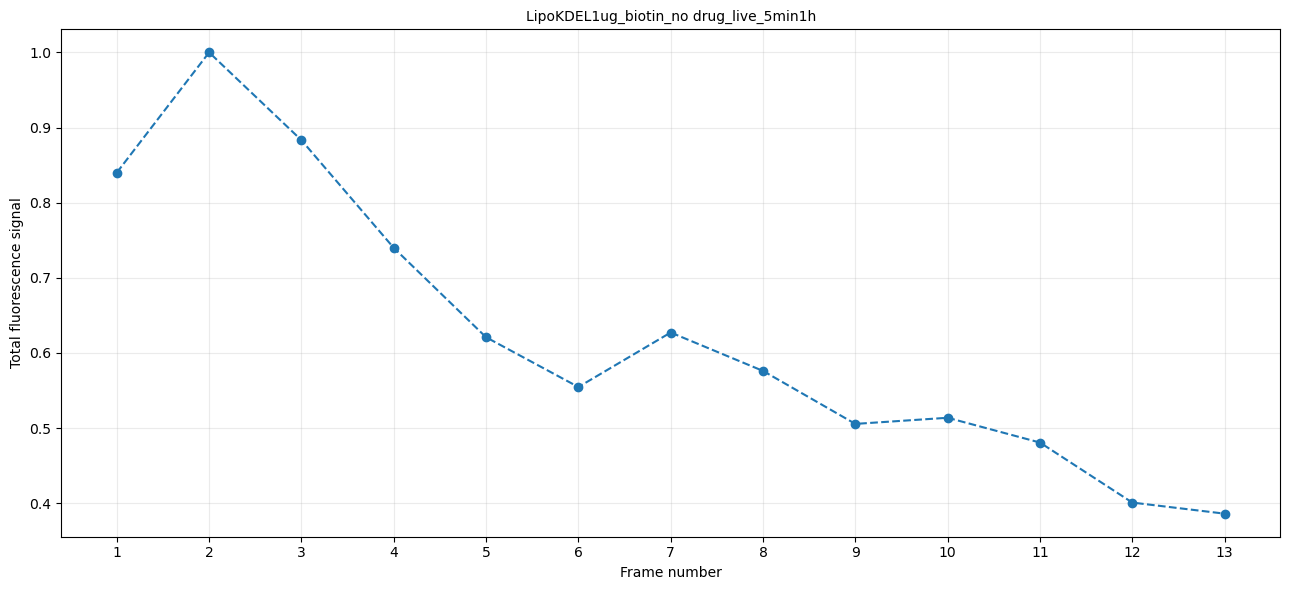

Value of threshold_yen 0.2437326539522059 and value of threshold_otsu 0.2314693757659314
Value of threshold_yen 0.21877552466299022 and value of threshold_otsu 0.21877552466299022
Value of threshold_yen 0.22092154411764708 and value of threshold_otsu 0.22392727941176477
Value of threshold_yen 0.24115188189338238 and value of threshold_otsu 0.20220809972426473
Value of threshold_yen 0.24825082107843138 and value of threshold_otsu 0.20068180147058823
Value of threshold_yen 0.21173392003676472 and value of threshold_otsu 0.21173392003676472
Value of threshold_yen 0.22604769914215686 and value of threshold_otsu 0.2139109099264706
Value of threshold_yen 0.24015722426470587 and value of threshold_otsu 0.20088623161764707
Value of threshold_yen 0.2484667578125 and value of threshold_otsu 0.1996880078125
Value of threshold_yen 0.27526209941789215 and value of threshold_otsu 0.18705656479779412
Value of threshold_yen 0.24162775428921573 and value of threshold_otsu 0.1966039491421569
Value of th

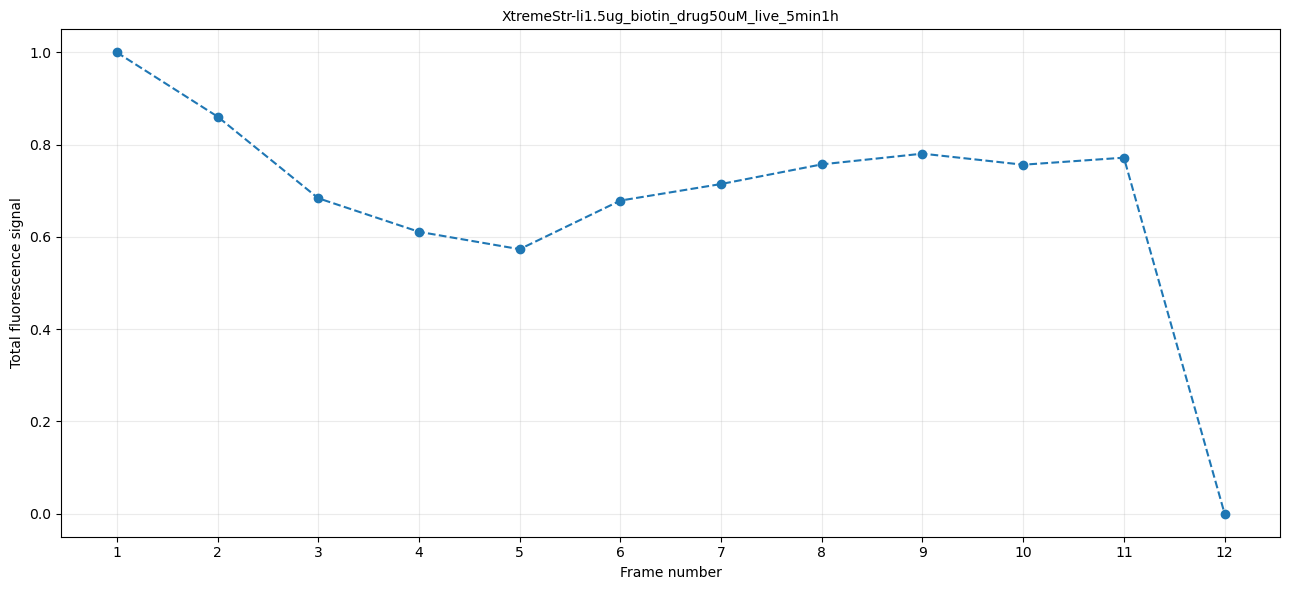

Value of threshold_yen 0.2594462025122549 and value of threshold_otsu 0.19945864123774515
Value of threshold_yen 0.2768178691789216 and value of threshold_otsu 0.17207597273284314
Value of threshold_yen 0.2923698184742647 and value of threshold_otsu 0.15879985064338237
Value of threshold_yen 0.26381975873161767 and value of threshold_otsu 0.16654543428308824
Value of threshold_yen 0.24907022288602948 and value of threshold_otsu 0.17915577435661767
Value of threshold_yen 0.23626613281249997 and value of threshold_otsu 0.20951902343749998
Value of threshold_yen 0.23741548177083333 and value of threshold_otsu 0.21926907552083333
Value of threshold_yen 0.2928612094056373 and value of threshold_otsu 0.18101471737132357


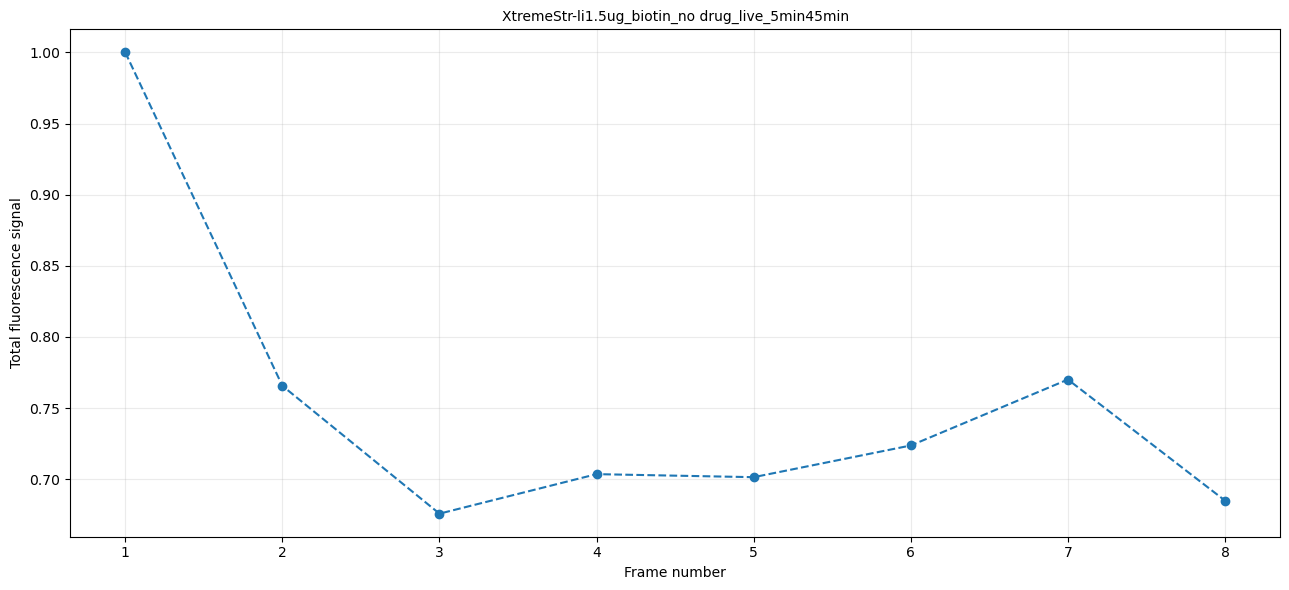

In [25]:
cwd = os.getcwd() #getting current working directory

temp = glob.glob(os.path.join(cwd, 'Videos', '*')) #in my current working directory, access videos folder and list me all the files inside
video_folders = [file for file in temp if not file.endswith(".avi")] #using list comprehension. access the files inside temp, isolate the files with '.avi', and exclude it. store as video_folders

all_video_values = [] #empty list to add the arrays generated for all 7 videos into 1 list, for downstream works.

def extract_fluorescenceData(folder_path): #creating a function called extract_fluorescenceData, to loop through the 7 different folders.
    total_fluorescence = [] #empty list to add the max fluoresence later and plot
    subdir_path = os.path.join(cwd, 'Videos', folder_path) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, img)
            if img.lower().endswith(('.jpg')): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                # print(img_gray)
                print(f'Value of threshold_yen {threshold_yen(img_gray)} and value of threshold_otsu {threshold_otsu(img_gray)}')
                # test_y = img.copy(img_gray)
                # test_o = img.copy(img_gray)
                # threshold_y = threshold_yen(img_gray)
                # threshold_o = threshold_otsu(img_gray)
                # test_y[test_y < threshold_y] = 0
                # test_o[test_o < threshhold_o] = 0
                # threshold_y = threshold_yen(img_gray)
                # img_gray_o = img_gray < threshold_otsu 
                # img_gray_y = img_gray < threshold_y
                total_fluorescence.append(img_gray.sum()) #sum up signal inside individual frames and append into total_fluorascence

    else:
        print(f'Subdirectory {video_folders} not found')
    return total_fluorescence #return here so can use in "histogrammer" function. this variable will be 'video1' in histogrammer function


def histogrammer(video1, i): #video1 is an array of the max fluorescence values, i simply stands for index
    video1_normalise = video1/max(video1) #normalising to highest sum fluorescent signal in the frames. 
    name = os.path.split(video_folders[i]) #split it by \\ into index, where [0] = your directory and [i] in this case is folder names
    x = range(1, len(video1)+1) #plotting frame 1 to n+1
    
    #plotting segment
    plt.figure(figsize = (13, 6)) #setting the figure size, has to be before plt.plot
    plt.plot(x, video1_normalise, linestyle = 'dashed', marker = 'o') #marker is the data point, marked as circle.
    
    #Labels & aesthetics
    plt.xticks(x) #this makes it show every tick in X axis
    plt.xlabel('Frame number', fontsize = 10)
    plt.ylabel('Total fluorescence signal', fontsize = 10)
    plt.grid(alpha = .25)
    plt.title(name[1], fontsize = 10) #name[1] as my first index will be my path, second index is filename
    plt.tight_layout()
    # plt.savefig(f'Graph for {name[1]}.jpg', dpi = 300) #added saving of plots!
    plt.show() #visualisation purposes only, for the output
    

#calling of the functions to do all the dirty work
for i, folder in enumerate(video_folders): #for index inside folder, count the number of folders inside the path video_folders
    video1 = extract_fluorescenceData(folder) #isolate the single videos, split into frames, change to grayscale, give add sum(fluorescence) per frame and save as video1
    all_video_values.append(video1) #append numpy total_fluorescence of this video from each iteration into all_video_values. Placed here instead of extract_fluorescenceData function if not next time i call it, it will append junk
    histogrammer(video1, i) #store the list of fluorescence signals as video1 and plot histogram